#### Atlanta Traffic Accidents DBSCAN Analysis
Goals:
- Analyze general lat/long DBSCAN for Atlanta traffic accident clusters via haversine distances
- Create various distance matrices for features available in the dataset and compare/analyze cluster results
- Analyze space/time relationship for hourly accidents locations
- Create visualizations to show accident prone locations

In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import haversine_distances, euclidean_distances
from sklearn import metrics
import matplotlib.pyplot as plt
import plotly.express as px
from pandas_profiling import ProfileReport
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#%matplotlib qt
%matplotlib inline

#### Import/Rename Features

In [2]:
df = pd.read_csv("crash-data.csv")

In [3]:
df = df.rename(columns={
    "Date and Time": "datetime",
    "Agency Name (Crash Level) ": "agency",
    "Area: County": "county",
    "Area: City": "city",
    "Roadway (From Crash Report)": "road",
    "Intersection Name (from Crash Report)": "intersection",
    "KABCO Severity": "severity",
    "Manner of Collision (Crash Level) ": "collision_type",
    "First Harmful Event (Crash Level) ": "first_event",
    "SHSP Emphasis Areas": "emphasis_areas",
    '# of Fatalities (Person Table)': "num_fatalities",
    '# Serious Injuries': "num_serious_injuries",
    "# Visible Injuries": "num_injuries",
    "# Complaint Injuries": "num_complaint_injuries",
    "# of Vehicles": "num_vehicles",
    "Operator / Driver Contributing Factor": "cause",
    "Roadway Contributing Factors (Crash Level) ": "roadway_factors",
    "Weather Conditions (Crash Level)": "weather_type",
    "Surface Condition (Crash Level) ": "surface_type",
    "Light Conditions (Crash Level)": "lighting",
    "Latitude ": "lat",
    "Longitude": "long"
})

#### Data Cleanup and Filtering
- Data already contains most recent accidents from 2020 via Atlanta only
- Filter out incorrect lat/long defined accidents, incorrect/wrong data outliers
- Convert datetime to datetime, remove unnecessary columns, potential collinear columns, drop redundant cols
- Create data processing Transformers for data transformers

In [4]:
# Filter outliers by lat/long, some data has obvious incorrect lat/long records
# Max lat/long for the Atlanta area
df = df[(df['long'] > -86.0) & (df['long'] < -80.0)]
df = df[(df['lat'] > 33.20) & (df['lat'] < 35.0)]

In [5]:
# Convert to datetime, create near_intersection var, drop unused variables
df['datetime'] = pd.to_datetime(df['datetime'])
df['near_intersection'] = np.where(df['intersection'].isnull(), False, True)
df.drop(['county', 'agency', 'city', 'intersection', 'first_event', 'cause', 'num_complaint_injuries'], axis=1, inplace=True)

#### Setup Transformers/Cleaning Functions
- JsonTransformer to flatten Json defined data columns
- OneHotEncoder for categorical
- LabelEncoder for severity
- DateTimeTransformer for converting datetime to hourly features (specificity)

In [6]:
def road_type(road_name):
    if(type(road_name) != str):
        return
    """Common road types, otherwise assume a standard street"""
    if 'hwy' in road_name.lower().rsplit(' ', 1)[-1] or \
        'highway' in road_name.lower().rsplit(' ', 1)[-1]:
        return 'Highway'
    elif road_name[0:2] == 'I ':
        return 'Interstate'
    elif 'rd' in road_name.lower().rsplit(' ', 1)[-1] or \
        'road' in road_name.lower().rsplit(' ', 1)[-1]:
        return 'Road'
    else:
        return 'Street'

In [7]:
df['road_type'] = df.apply(lambda row: road_type(row['road']), axis=1)
df.drop(['road'], axis=1, inplace=True)

In [8]:
def parse_list(item):
    if(type(item) != str):
        return
    if '[' in item:
        return json.loads(item)
    else:
        return item

In [9]:
class JsonTransformer(BaseEstimator, TransformerMixin):
    """Embedded Json Transformer, create dummies and join to original features"""
    def __init__(self, feature_name):
        self.feature_name = feature_name
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_ = X.copy()
        X_[self.feature_name + '_new'] = X_.apply(lambda row: parse_list(row[self.feature_name]), axis=1)
        dummies = X_[self.feature_name + '_new'].explode().str.get_dummies()
        dummies = dummies.groupby(level=0).sum().add_prefix('{0}_'.format(self.feature_name))
        X_.drop([self.feature_name + '_new'], axis=1, inplace=True)
        return dummies

In [10]:
class DateTimeTransformer(BaseEstimator, TransformerMixin):
    """Datetime create separate features for hour"""
    def __init__(self, feature_name):
        self.feature_name = feature_name
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_ = X.copy()
        X_['hour'] = pd.DatetimeIndex(X_[self.feature_name]).hour
        #X_['dayofweek'] = pd.DatetimeIndex(X_[self.feature_name]).dayofweek
        X_.drop([self.feature_name], axis=1, inplace=True)
        return X_

In [11]:
class SeasonTransformer(BaseEstimator, TransformerMixin):
    """Datetime create separate feature for season"""
    def __init__(self, feature_name):
        seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
        self.month_to_season = dict(zip(range(1,13), seasons))
        self.feature_name = feature_name
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_ = X.copy()
        X_['season'] = pd.DatetimeIndex(X_[self.feature_name]).month.map(self.month_to_season)
        X_.drop([self.feature_name], axis=1, inplace=True)
        return X_

In [12]:
def dist_geo(X):
    """Geo distance. X and Y should be lat/lon of shape (n_sample, 2)"""
    X_in_radians = np.radians(X)
    dist = haversine_distances(X_in_radians)
    dist *= 6371.0
    return dist

In [13]:
def dist_euclidean(X):
    """Euclidean distance. X should be the feature representations of shape (n_sample, dim_embeddings)"""
    return euclidean_distances(X)

In [14]:
def normalize_dist_matrix(dist_matrix):
        """MinMax scaling of distances in [0,1]"""
        return (dist_matrix - dist_matrix.min()) / (dist_matrix.max() - dist_matrix.min())

In [15]:
def setup_data(df, coordinate_features, desc_features=[]):
    """Setup distance matrix based on lat/long features and primary descriptive
    features
    Args:
        df: input dataframe of simplified data
        coordinate_features: lat/long features
        desc_features: descriptive features (Optional)
    Returns transformed data, distance matrix of transformed data
    """
    if len(desc_features) > 0:
        cols = coordinate_features + desc_features
    else:
        cols = coordinate_features
        
    df2 = df[cols]
    df2.reset_index(drop=True, inplace=True)
    
    for feature in desc_features:
        if feature == 'severity':
            ord_enc = OrdinalEncoder(categories=[['Unknown', '(O) No Injury', '(C) Possible Injury / Complaint',
               '(B) Suspected Minor/Visible Injury','(A) Suspected Serious Injury','(K) Fatal Injury']])
            severity = pd.get_dummies(ord_enc.fit_transform(df2[[feature]]).ravel(), prefix="severity")
            df2 = df2.join(severity)
            df2 = df2.drop([feature], axis=1)
        elif feature == 'emphasis_areas' or feature == 'roadway_factors':
            transformer = JsonTransformer(feature)
            df2 = df2.join(transformer.fit_transform(df2))
            df2 = df2.drop([feature], axis=1)
        elif feature == 'datetime':
            dt_transformer = DateTimeTransformer('datetime')
            hours = pd.get_dummies(dt_transformer.fit_transform(df2)['hour'], prefix="hour")
            df2 = df2.join(hours)
            df2 = df2.drop(feature, axis=1)
        else:
            df2 = df2.join(pd.get_dummies(df2[feature], prefix=feature))
            df2 = df2.drop(feature, axis=1)
            
    # Spatial features
    dist_matrix_geo = normalize_dist_matrix(dist_geo(np.asarray(df2[['lat','long']])))
    
    # Euclidean features
    if len(desc_features) > 0:
        dist_data = df2.loc[:, ~df2.columns.isin(['lat', 'long'])].to_numpy()
        dist_matrix_features = normalize_dist_matrix(dist_euclidean(dist_data))
        dist_matrix = dist_matrix_geo
        dist_matrix += dist_matrix_features
    else:
        dist_matrix = dist_matrix_geo
    
    print("Combined dist matrix shape: %s" % str(dist_matrix.shape))
    return df2, dist_matrix

In [16]:
class HDBScan():
    """Generic HDBScan class for consuming distance matrix and feature dataframe
    """
    
    def __init__(self, df, dist_matrix, min_clust_size=50, seed=42):
        """
        Args:
            df: feature dataframe
            dist_matrix: combined distance matrix for precomputed dist
        """
        self.df = df
        self.dist_matrix = dist_matrix
        self.min_clust_size = min_clust_size
        self.clusterer = hdbscan.HDBSCAN(min_cluster_size=self.min_clust_size,
                                         metric='precomputed')
        self.seed = seed
        self.coordinates_df = None

        
    def run(self):
        np.random.seed(self.seed)
        labels = self.clusterer.fit_predict(self.dist_matrix)
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)
        print('Silhouette score: %.4f' % metrics.silhouette_score(self.dist_matrix, 
                                                                labels, 
                                                                metric="precomputed"))

        # Combine coordinates/features
        coordinates = self.df[['lat', 'long']].to_numpy()
        coordinates_labels = np.column_stack((coordinates, labels))

        # Create labels
        self.coordinates_df = pd.DataFrame(coordinates_labels, columns = ['lat', 'long', 'label'])
        self.coordinates_df['label'] = self.coordinates_df['label'].astype(object)

        # Join other features for plotting analysis
        features = self.df[self.df.columns[~self.df.columns.isin(['lat', 'long'])]]
        features = features.astype(object)
        features.reset_index(drop=True, inplace=True)
        self.coordinates_df.reset_index(drop=True, inplace=True)
        self.coordinates_df = self.coordinates_df.join(features)

        
    def plot(self, savefigname=None):
        # Visualize 2-D coordinates with DBScan
        px.set_mapbox_access_token(open(".mapbox_token").read())
        map_data = self.coordinates_df[(self.coordinates_df.label != -1)] # Ignore noise points (-1)
        fig = px.scatter_mapbox(map_data,
                                lat="lat",
                                lon="long",
                                color="label",
                                size_max=30,
                                zoom=10,
                                template='plotly_dark'
                               )
        if savefigname is not None:
            fig.write_image('images/{0}.png'.format(savefigname))
            fig.write_html('images/{0}.html'.format(savefigname))
        fig.show()
        

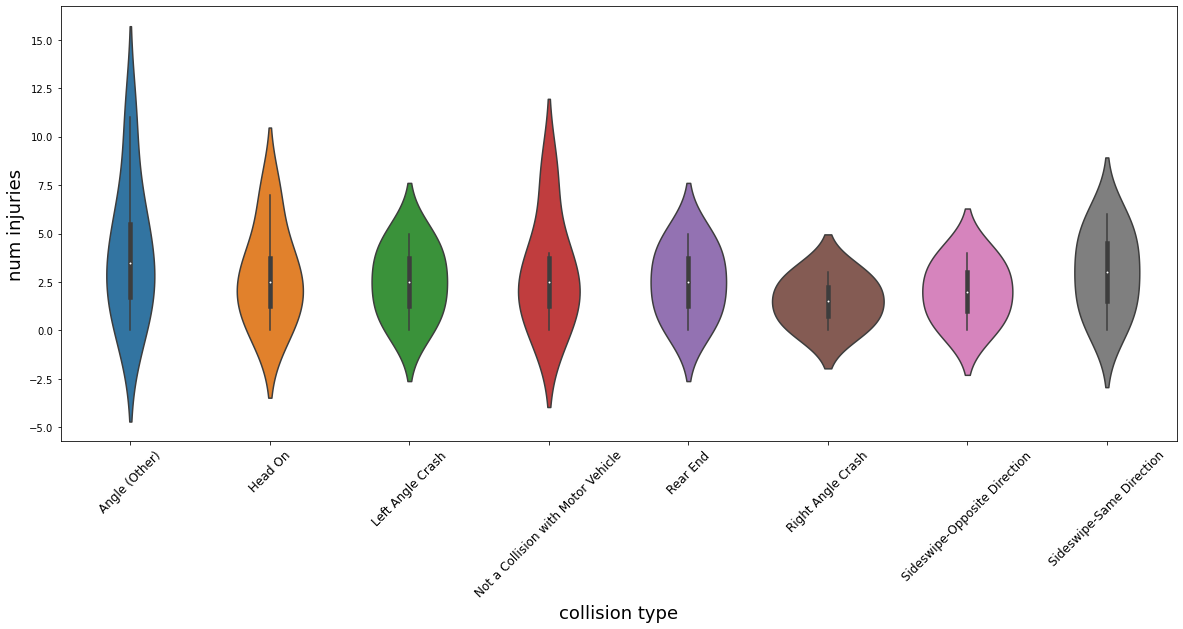

In [17]:
collision_df_num = df[(df.collision_type != '(None)')].groupby(['collision_type', 'num_injuries']).size().reset_index(name="count")
fig = plt.figure(1, figsize=(20, 8))
ax = sns.violinplot(x="collision_type", y="num_injuries", data=collision_df_num)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.xlabel('collision type')
plt.ylabel('num injuries')
plt.xticks(rotation = 45)
plt.xticks(fontsize=12)
plt.savefig("./images/num_injuries_collision_violin.png", dpi=300, bbox_inches = "tight")

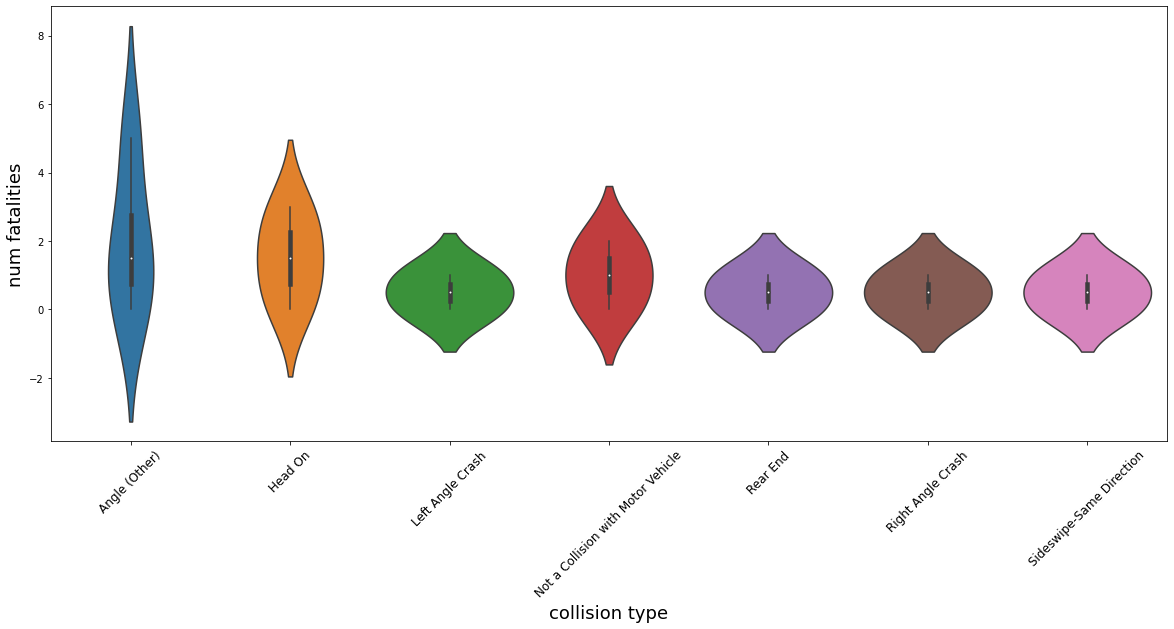

In [18]:
collision_df_fatal = df[(df.collision_type != '(None)') & 
                        (df.collision_type != 'Sideswipe-Opposite Direction')].groupby(['collision_type', 'num_fatalities']).size().reset_index(name="count")
fig = plt.figure(1, figsize=(20, 8))
ax = sns.violinplot(x="collision_type", y="num_fatalities", data=collision_df_fatal)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.xlabel('collision type')
plt.ylabel('num fatalities')
plt.xticks(rotation = 45)
plt.xticks(fontsize=12)
plt.savefig("./images/num_fatalities_collision_violin.png", dpi=300, bbox_inches = "tight")

#### Create Distance Matrices for Space/Time and Others

In [19]:
space_df, space_dist = setup_data(df, ['lat','long'])
space_time_df, space_time_dist = setup_data(df, ['lat','long'], ['datetime'])
roads_df, roads_dist = setup_data(df, ['lat','long'], ['road_type'])
factors_df, factors_dist = setup_data(df, ['lat','long'], ['roadway_factors'])

Combined dist matrix shape: (24113, 24113)
Combined dist matrix shape: (24113, 24113)
Combined dist matrix shape: (24113, 24113)
Combined dist matrix shape: (24113, 24113)


#### HDBSCAN (Optimized DBSCAN alternative to find eps)
- Source: https://github.com/scikit-learn-contrib/hdbscan
- Much faster than standard DBSCAN, utilizes algorithm to find optimal eps, params
- Automatically determines optimal fit
- Visualizations from optimal determinations

#### Standard HDBSCAN (Lat/Long)

Estimated number of clusters: 100
Estimated number of noise points: 12389
Silhouette score: -0.0936


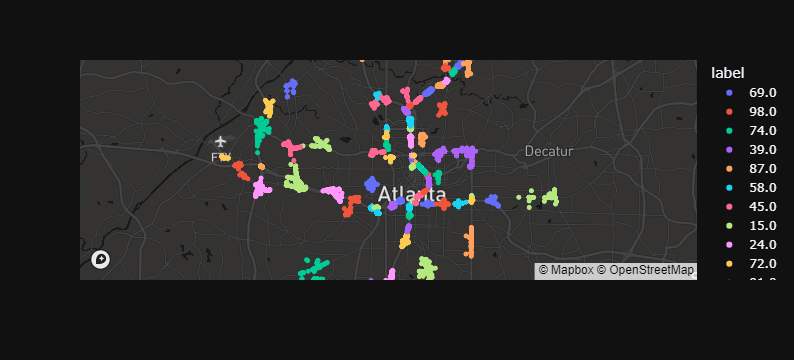

In [20]:
# Standard coordinates only features
db = HDBScan(space_df, space_dist)
db.run()
db.plot("accidents_cluster")

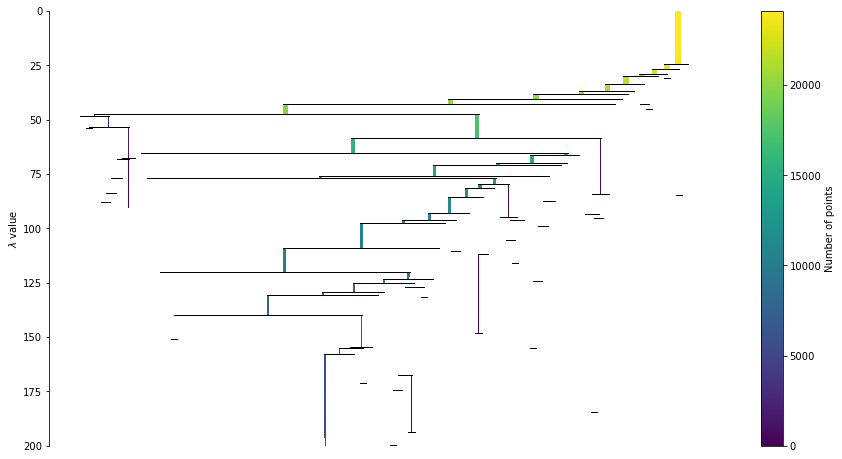

In [21]:
plt.figure(1, figsize=(15, 8))
plt.ylim(0, 200)
db.clusterer.condensed_tree_.plot()
plt.savefig("./images/spatial_cluster_dendogram.png", dpi=300, bbox_inches = "tight")

C:\Users\Dillo\Anaconda3\envs\ox\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Dillo\Anaconda3\envs\ox\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Dillo\Anaconda3\envs\ox\lib\site-packages\seaborn\distributions.py:2103: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



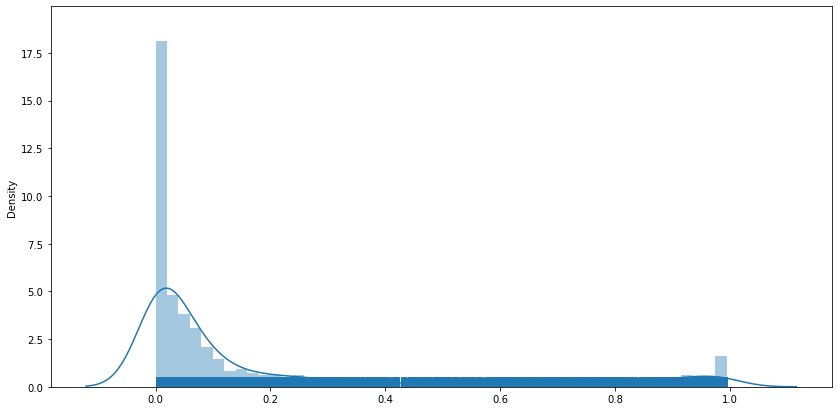

In [22]:
plt.figure(1, figsize=(14, 7))
sns.distplot(db.clusterer.outlier_scores_[np.isfinite(db.clusterer.outlier_scores_)], rug=True)
plt.savefig("./images/spatial_cluster_outliers_density.png", dpi=300, bbox_inches = "tight")

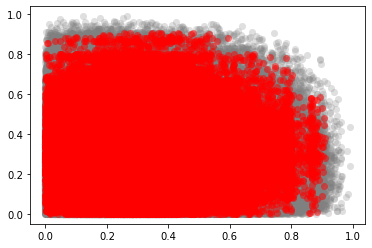

In [23]:
# Visualize outliers if possible (lat/long's are extremely close together, would be better scaled)
n_samples = 100
threshold = pd.Series(db.clusterer.outlier_scores_[0:n_samples]).quantile(0.9)
outliers = np.where(db.clusterer.outlier_scores_[0:n_samples] > threshold)[0]
plt.scatter(db.dist_matrix[0:n_samples, :], db.dist_matrix[0:n_samples, :].T, s=50, c='gray', linewidth=0, alpha=0.25)
plt.scatter(db.dist_matrix[outliers][0:n_samples, :], db.dist_matrix[outliers][0:n_samples, :].T, c='red', s=50, linewidth=0, alpha=0.5)
plt.show()

#### Space/Time HDBSCAN

Estimated number of clusters: 33
Estimated number of noise points: 1906
Silhouette score: 0.5655


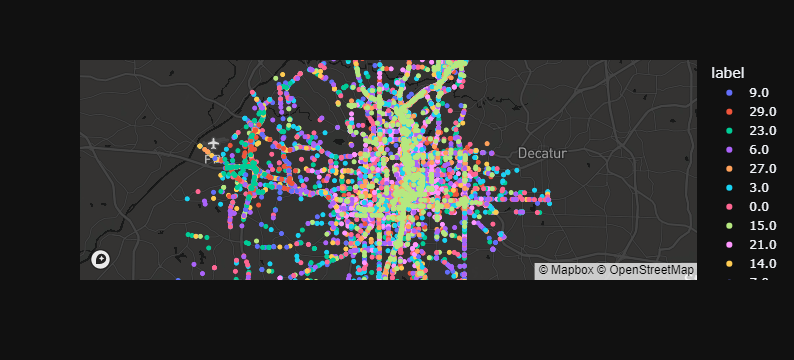

In [24]:
# Space/time features (hourly)
db = HDBScan(space_time_df, space_time_dist)
db.run()
db.plot("accidents_space_time")

In [25]:
coordinates_hours = db.coordinates_df

In [26]:
# Copy standard clean df with datetime feature
df3 = df[['lat', 'long', 'datetime']]
df3.reset_index(drop=True, inplace=True)
# Fit hour column without one-hot encoding for 3-D analysis
dt_transformer = DateTimeTransformer('datetime')
hours = dt_transformer.fit_transform(df3)['hour']
df3 = df3.join(hours)
df3 = df3.drop('datetime', axis=1)

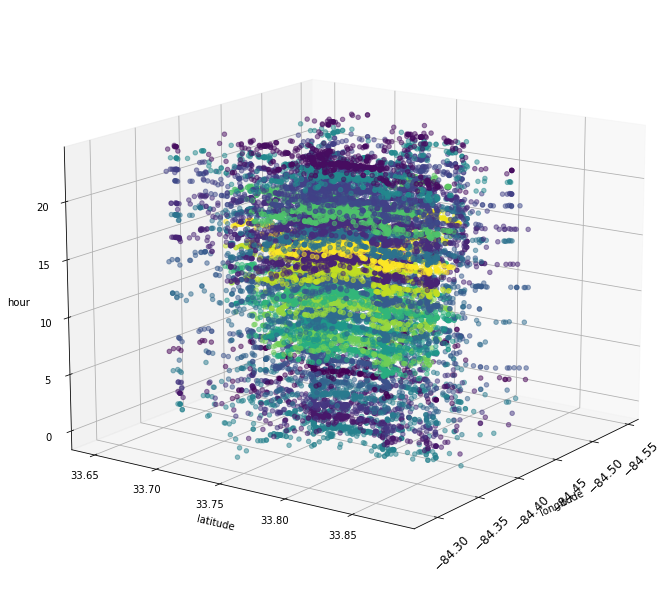

In [27]:
# 3D space/time plot of hour/lat/long
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, auto_add_to_figure=False )
ax.view_init(15, 35)
space_time = df3.iloc[coordinates_hours.index[coordinates_hours.label != -1]]
coordinates_time = coordinates_hours[coordinates_hours.label != -1]
ax.scatter(space_time['long'], space_time['lat'], space_time['hour'], c = coordinates_time['label'], alpha=0.5)
fig.add_axes(ax)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_zlabel('hour')
ax.dist = 9
plt.xticks(rotation = 45)
plt.xticks(fontsize=12)
plt.savefig("./images/space_time_labels_3d.png", dpi=300, bbox_inches = "tight")
plt.show()

In [28]:
print("Mean latitude coords for hour 23: {0}".format(coordinates_hours[coordinates_hours['hour_23'] == 1]['lat'].mean()))
print("Mean longitude coords for hour 23: {0}".format(coordinates_hours[coordinates_hours['hour_23'] == 1]['long'].mean()))
print("Mean latitude coords for hour 8: {0}".format(coordinates_hours[coordinates_hours['hour_8'] == 1]['lat'].mean()))
print("Mean longitude coords for hour 8: {0}".format(coordinates_hours[coordinates_hours['hour_8'] == 1]['long'].mean()))

Mean latitude coords for hour 23: 33.76189642212518
Mean longitude coords for hour 23: -84.40396464337701
Mean latitude coords for hour 8: 33.766570601890756
Mean longitude coords for hour 8: -84.40212202100841


#### Road Types HDBSCAN

Estimated number of clusters: 104
Estimated number of noise points: 9496
Silhouette score: 0.0617


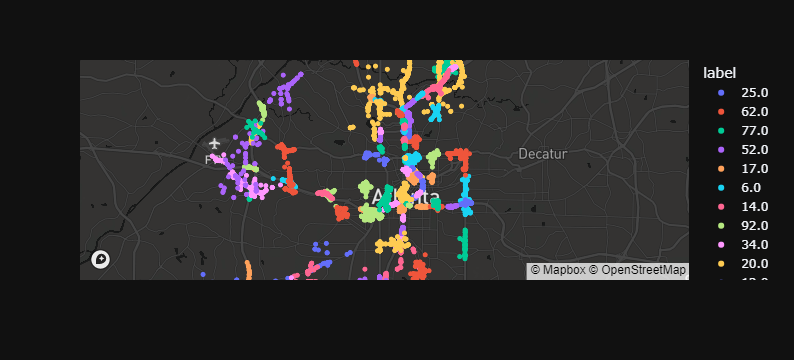

In [29]:
db = HDBScan(roads_df, roads_dist)
db.run()
db.plot("roads_cluster")
coordinates_road_type = db.coordinates_df

In [30]:
px.set_mapbox_access_token(open(".mapbox_token").read())
filter_condition = (coordinates_road_type['road_type_Highway'] <= 0) & \
    (coordinates_road_type['road_type_Interstate'] >= 1) & \
    (coordinates_road_type['road_type_Road'] <= 0) & \
    (coordinates_road_type['road_type_Street'] <= 0)
map_data = coordinates_road_type[(coordinates_road_type.label != -1) & (filter_condition)] # Ignore noise points (-1)
fig = px.scatter_mapbox(map_data,
                        lat="lat",
                        lon="long",
                        color="label",
                        size_max=30,
                        zoom=10,
                        template='plotly_dark'
                       )
fig.write_image('images/interstate_clusters.png')
fig.write_html('images/interstate_clusters.html')
#fig.show()

In [31]:
filter_condition = ((coordinates_road_type['road_type_Highway'] >= 1) | \
    (coordinates_road_type['road_type_Road'] >= 1)) & \
    (coordinates_road_type['road_type_Interstate'] <= 0) & \
    (coordinates_road_type['road_type_Street'] <= 0)
map_data = coordinates_road_type[(coordinates_road_type.label != -1) & (filter_condition)] # Ignore noise points (-1)
fig = px.scatter_mapbox(map_data,
                        lat="lat",
                        lon="long",
                        color="label",
                        size_max=30,
                        zoom=10,
                        template='plotly_dark'
                       )
fig.write_image('images/roads_clusters.png')
fig.write_html('images/roads_clusters.html')
#fig.show()

In [32]:
px.set_mapbox_access_token(open(".mapbox_token").read())
filter_condition = (coordinates_road_type['road_type_Highway'] <= 0) & \
    (coordinates_road_type['road_type_Interstate'] <= 0) & \
    (coordinates_road_type['road_type_Road'] <= 0) & \
    (coordinates_road_type['road_type_Street'] >= 1)
map_data = coordinates_road_type[(coordinates_road_type.label != -1) & (filter_condition)] # Ignore noise points (-1)
fig = px.scatter_mapbox(map_data,
                        lat="lat",
                        lon="long",
                        color="label",
                        size_max=30,
                        zoom=10,
                        template='plotly_dark'
                       )
fig.write_image('images/street_clusters.png')
fig.write_html('images/street_clusters.html')
#fig.show()

#### Other Features HDBSCAN

In [33]:
db = HDBScan(factors_df, factors_dist)
db.run()

Estimated number of clusters: 83
Estimated number of noise points: 12983
Silhouette score: -0.1831


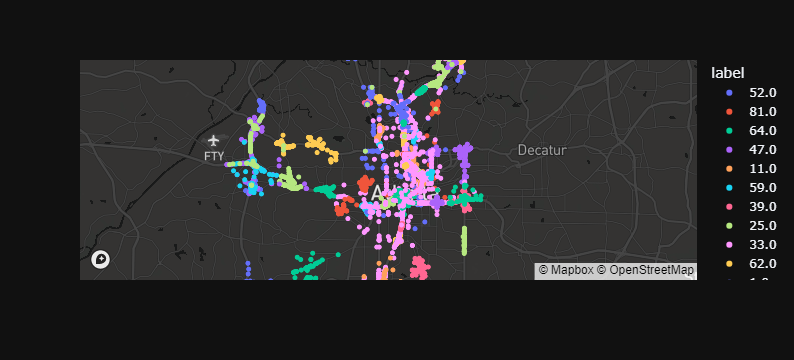

In [34]:
db.plot("factors_clusters")

In [35]:
# View conditional specific accidents
#db.coordinates_df.iloc[db.coordinates_df.index[db.coordinates_df.label == 3.0]]